In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display
import tensorflow as tf

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

In [2]:
train_audio_path = '/home/kcs/Git/KagglePractice/Speech_Representation_And_Data_Exploration/dataSets/prepDataSet/'
filename = 'AWM/AWM_01.wav'
# train_audio_path = '/home/kcs/Git/KagglePractice/Speech_Representation_And_Data_Exploration/dataSets/train/audio/'
# filename =  'yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [3]:
# 로그 스펙트로그램을 계산하는 함수
def log_specgram(audio, sample_rate, window_size=20, step_size = 10,
                eps = 1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    # 연속 푸리에 변환을 해 스펙트로그램을 계산하는 함수
    freqs, times, spec = signal.spectrogram(audio,
                                           fs = sample_rate,
                                           window='hann',
                                            #여기 윈도우 매개변수에 들어간 부분이
                                            #window function들 중에 하나이다.
                                            #시가눅에서 Window Function을 곱하는 것은, 주파수 축에서 Filtering이라고 한단다. 
                                            #Window의 주파수 스펙트럼을, 원래 입력 신호의 주파수 스펙트럼과 convolution해서 조금 더 부드럽고
                                            #side lobe가 사라진 주파수 스펙트럼을 만들 수 있다. But 단점으로는 Main lobe가 두꺼워진다는 점.
                                            #Cosine, Raised Cosine, Hamming, Hanning, Blackman, Triangular, Gaussian 등이 있다.
                                           nperseg = nperseg,
                                            
                                           noverlap=noverlap,
                                            #각 윈도우들을 겹치게 할지를 결정하는 매개변수
                                           detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [4]:
# 주파수, 시간, 스펙트로그램을 Sample들과, Sample_Rate에 대해 값들을 계산한다.
freqs, times, spectrogram = log_specgram(samples, sample_rate)


In [5]:
freqs_size = len(freqs)

In [6]:
times_size = len(times)

In [7]:
len(spectrogram)
# 스펙트로그램 자체는 99개 (시간 축과 매칭됨)

149

In [8]:
len(spectrogram[0])
# 스펙트로그램 벡터의 원소 수는 161개(주파수 축과 매칭됨)

481

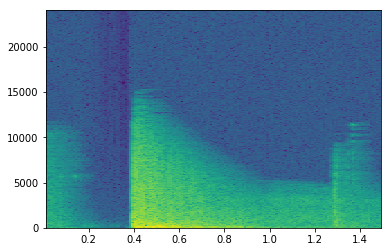

In [9]:
plt.imshow(spectrogram.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])

In [10]:
def custom_fft(y, fs):
    T = 1.0 / fs
    # Sample_rate 의 역수 ( 주기 )
    N = y.shape[0]
    # 데이터의 1차원의 수 (샘플의 수)
    yf = fft(y)
    # 데이터를 가지고 fft를 취한후에
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # x의 범위는 0부터 fs/2(sampling_rate의 반)까지, 쪼개는 개수는 샘플의 수를 2로 나눈 값의 정수형
    vals = 2.0/N * np.abs(yf[0:N//2])
    # 벨류 값은 헷갈린다... 뭐지 이게.. 2를 샘플의 수로 나누고 그걸 fft취한 값들을 0: 샘플의 수를 2로 나눈 값의 정수형(걍 범위인듯)
    # 그걸 취해서 벨류로 던져준다. 결과 적으로는 길이만 줄인거라고 할 수 있다. 
    return xf,vals

AWM


/usr/local/lib/python3.5/dist-packages/librosa/display.py:656: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.



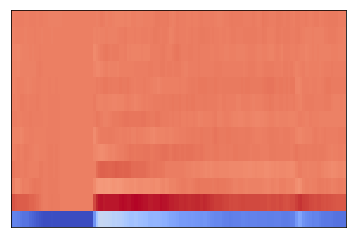

Kar98


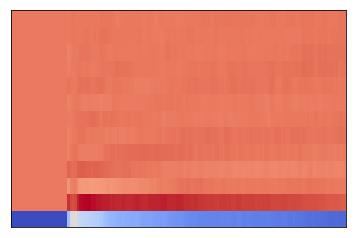

M24


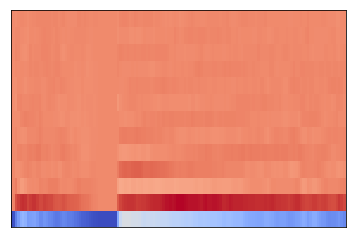

MK14


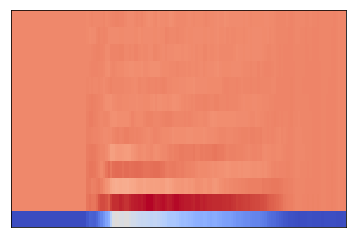

SKS


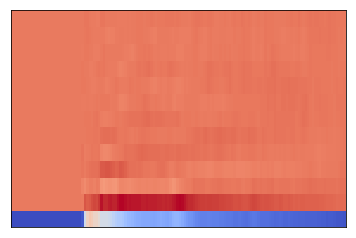

mini


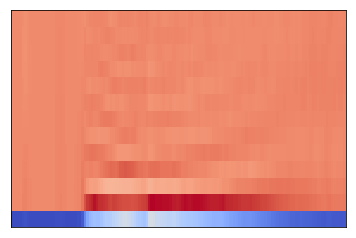

In [11]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()

for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    sample_rate, samples = wavfile.read(join(train_audio_path, direct, '_01.wav'))
    S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    #     freqs, times, spec = log_specgram(samples,sample_rate)
    print(direct)
#     plt.imshow(spec.T, aspect='auto', origin='lower',
#           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    librosa.display.specshow(mfcc)

    plt.show()
# print((spec - spec.min())/(spec.max() - spec.min()))
# freqs_size, times_size =  mfcc.shape



In [12]:
max_sr = 0
for directory in dirs:
    sr, data = wavfile.read(join(train_audio_path, directory, os.listdir(join(train_audio_path, directory))[0]))
    if max_sr < sr:
        max_sr = sr

print('Max Sample Rate : ' + str(max_sr))
print('Number of labels: ' + str(len(dirs)))
# 라벨이 몇개 있는지 확인해보자.

print(dirs)
al = []
spec_all = []
target_all = []
target_value = {}

for i, direct in enumerate(dirs):
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    target_value[direct] = i
    print(str(i)+':' + str(direct) + ' ', end='')
    for wav in waves:
        # 파일을 읽어다가.
        sample_rate, samples = wavfile.read(join(train_audio_path, direct, wav))
        # print(sample_rate)
        # The sample_rate that we want to deal with is 16000(Voice)
        # BG is 72000
        if samples.shape[0] != 72000:
            continue
        target_all.append(direct)
        # 스펙트로그램도 그려보자.
#          S = librosa.feature.melspectrogram(samples, sr = sample_rate, n_mels=128)
#         log_S = librosa.power_to_db(S, ref = np.max)
#         mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
#         print(mfcc.shape)
#         delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        freqs, times, spec = log_specgram(resamples, max_sr)
        spec = (spec - spec.min())/(spec.max() - spec.min())
        # 정규화 안해주면 로그스케일로 내린 값이 음수여서 relu통과할때 0 이된다 
        # 스펙트로 그램도 spec_all 이라는 리스트에 더해주고
#         spec_all.append(np.reshape(spec,(freqs_size,times_size)))
        al.append([np.reshape(spec,(freqs_size,times_size)), direct])

Number of labels: 6
['AWM', 'Kar98', 'M24', 'MK14', 'SKS', 'mini']
1:AWM 2:Kar98 3:M24 4:MK14 5:SKS 6:mini 

In [13]:
# Shuffle Data
np.random.shuffle(al)
# Split Data to Spectrogram and Target(Label)
spec_all = np.reshape(np.delete(al,1,1),(len(al)))
target_all = [i for i in np.delete(al,0,1).tolist()]

In [14]:
def cnn_model(input_images, batch_size,drop_out_rate=0.1, is_training=False, train_logical=True):
    def truncated_normal_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer = tf.truncated_normal_initializer(stddev=0.05)))

    def zero_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.constant_initializer(0.0)))
    
    with tf.variable_scope('conv1') as scope:
        conv1_kernel = truncated_normal_var(name='conv_kernel1',shape=[11,11,1,64],
                                           dtype= tf.float32)
        conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1,3,3,1], padding='SAME')
        conv1_bias = truncated_normal_var(name='conv_bias1', shape=[64], dtype=tf.float32)
        conv1_add_bias = tf.nn.bias_add(conv1,conv1_bias)
        relu_conv1 = tf.nn.relu(conv1_add_bias)
    
    norm1= tf.nn.lrn(relu_conv1,depth_radius=5, bias=2.5,alpha=1e-3, beta=0.75, name='norm1')
    
    with tf.variable_scope('conv2') as scope:
        conv2_kernel = truncated_normal_var(name='conv_kernel2', shape=[5, 5, 64, 32], dtype=tf.float32)
        conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1, 1, 1, 1], padding='SAME')
        conv2_bias = truncated_normal_var(name='conv_bias2', shape=[32], dtype=tf.float32)
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        relu_conv2 = tf.nn.relu(conv2_add_bias)

    norm2 = tf.nn.lrn(relu_conv2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    
    with tf.variable_scope('conv3') as scope:
        conv3_kernel = truncated_normal_var(name='conv_kernel3', shape=[3, 3, 32, 32], dtype=tf.float32)
        conv3 = tf.nn.conv2d(norm2, conv3_kernel, [1, 1, 1, 1], padding='SAME')
        conv3_bias = truncated_normal_var(name='conv_bias3', shape=[32], dtype=tf.float32)
        conv3_add_bias = tf.nn.bias_add(conv3, conv3_bias)
        relu_conv3 = tf.nn.relu(conv3_add_bias)

    pool = tf.nn.max_pool(relu_conv3, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool_layer')
    norm3 = tf.nn.lrn(pool, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm3')
    reshaped_output = tf.reshape(norm3, [batch_size, -1])
    reshaped_dim = reshaped_output.get_shape()[1].value
    
    with tf.variable_scope('full1') as scope:
        full_weight1 = truncated_normal_var(name='full_mult1', shape=[reshaped_dim, 384], dtype=tf.float32)
        full_bias1 = truncated_normal_var(name='full_bias1', shape=[384], dtype=tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output, full_weight1), full_bias1))

    with tf.variable_scope('full2') as scope:
        full_weight2 = truncated_normal_var(name='full_mull2', shape=[384, 192], dtype=tf.float32)
        full_bias2 = truncated_normal_var(name='full_bias2', shape=[192], dtype=tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1, full_weight2), full_bias2))

    with tf.variable_scope('full3') as scope:
        full_weight3 = truncated_normal_var(name='full_mull3', shape=[192, len(target_value)], dtype=tf.float32)
        full_bias3 = truncated_normal_var(name='full_bias3', shape=[len(target_value)], dtype=tf.float32)
        final_output = tf.nn.relu(tf.add(tf.matmul(full_layer2, full_weight3), full_bias3))
    final_output = tf.layers.dropout(final_output, rate=drop_out_rate, training=is_training)
    
    return final_output

In [15]:
# Parameters
lr = 0.001
generations = 20000
num_gens_to_wait = 250
drop_out_rate = 0.05
# this for Voice
batch_size = 32

# this for BG Sound
# batch_size = 16

In [16]:
# Get indices for train 70%
train_indices = np.random.choice(len(target_all),
                                 round(len(target_all) * 0.7), replace=False)
# Get indices for test 30%
test_indices = np.array(list(set(range(len(target_all)))
                                 - set(train_indices)))

spec_vals = np.array([x for x in spec_all])
target_vals = np.array([x for x in target_all])

train_spec = spec_vals[train_indices][:]
train_target = target_vals[train_indices][:]
test_spec = spec_vals[test_indices][:]
test_target = target_vals[test_indices][:]

In [17]:
# Convert String Label to one-of-C code Label
temp = []
for v in train_target:
    temp.append(target_value[v[0]])
train_target = np.array(temp)

temp = []
for v in test_target:
    temp.append(target_value[v[0]])
test_target = np.array(temp)

In [18]:
# Define PlaceHolders
x_input_shape = (batch_size, freqs_size,times_size,1)
y_input_shape = (batch_size, )
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
y_target = tf.placeholder(tf.int32, shape=y_input_shape)
eval_input_shape = (batch_size, freqs_size, times_size,1)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape=y_input_shape)

In [19]:
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
with tf.variable_scope('scope',reuse=tf.AUTO_REUSE) as scope:
    model_output = cnn_model(x_input,batch_size,drop_out_rate=drop_out_rate, is_training=True)
    test_model_output = cnn_model(eval_input,batch_size)


In [28]:
targets = tf.squeeze(tf.cast(y_target,tf.int32))
# print(y_target.shape)
# Define loss function Reduce_mean
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)
# We use AdamOptimizer to minimize loss function
# my_optimizer = tf.train.AdagradOptimizer(learning_rate = lr)
# Momentum series is suck but we can use adam optimizer modifing epsilon
my_optimizer = tf.train.AdamOptimizer(learning_rate=lr, epsilon=10e-2)
# my_optimizer = tf.train.AdamOptimizer(learning_rate = lr)

# my_optimizer = tf.train.MomentumOptimizer(learning_rate = lr,momentum=0.9)
train_step = my_optimizer.minimize(loss)
# Initializing global_variables
init = tf.global_variables_initializer()
sess.run(init)

In [21]:
# Define def to calculate accuracy
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return (100. * num_correct)/ batch_predictions.shape[0]


In [22]:
print('Train_Spectrogram Demension : ' + str(np.shape(train_spec)))

Train_Spectrogram Demension : (2021, 481, 149)


In [23]:
print('Train_Label Demension : ' + str(np.shape(train_target)))

Train_Label Demension : (2021,)


In [24]:
print('Test_Spectrogram Demension : ' + str(np.shape(test_spec)))

Test_Spectrogram Demension : (866, 481, 149)


In [25]:
print('Test_Label Demension : ' + str(np.shape(test_target)))

Test_Label Demension : (866,)


In [26]:
print('Number Of Labels : ' + str(len(target_value)))

Number Of Labels : 6


In [29]:
train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(train_spec),size = batch_size)
    rand_x = train_spec[rand_index]
    rand_x = np.expand_dims(rand_x, -1)
    rand_y = train_target[rand_index]

    sess.run(train_step,feed_dict = {x_input: rand_x, y_target: rand_y})
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict={x_input: rand_x, y_target: rand_y})
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    # logging temp result
    if (i + 1) % 50 == 0:
        eval_index = np.random.choice(len(test_spec), size=batch_size)
        eval_x = test_spec[eval_index]
        eval_x = np.expand_dims(eval_x, -1)
        eval_y = test_target[eval_index]

        test_preds = sess.run(test_prediction, feed_dict={eval_input: eval_x})
        temp_test_acc = get_accuracy(test_preds, eval_y)

        # Logging and Printing Results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        acc_and_loss = [(i + 1), temp_train_loss, temp_train_acc,
                            temp_test_acc]
        acc_and_loss = [np.round(x, 10) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.10f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 50. Train Loss: 1.7826703787. Train Acc (Test Acc): 25.00 (15.62)
Generation # 100. Train Loss: 1.7599240541. Train Acc (Test Acc): 31.25 (28.12)
Generation # 150. Train Loss: 1.7310385704. Train Acc (Test Acc): 31.25 (12.50)
Generation # 200. Train Loss: 1.7518124580. Train Acc (Test Acc): 28.12 (21.88)
Generation # 250. Train Loss: 1.7403211594. Train Acc (Test Acc): 25.00 (34.38)
Generation # 300. Train Loss: 1.7892657518. Train Acc (Test Acc): 18.75 (15.62)
Generation # 350. Train Loss: 1.6924099922. Train Acc (Test Acc): 40.62 (28.12)
Generation # 400. Train Loss: 1.6352810860. Train Acc (Test Acc): 37.50 (34.38)
Generation # 450. Train Loss: 1.7704976797. Train Acc (Test Acc): 21.88 (34.38)
Generation # 500. Train Loss: 1.6676846743. Train Acc (Test Acc): 31.25 (40.62)
Generation # 550. Train Loss: 1.6204226017. Train Acc (Test Acc): 31.25 (34.38)
Generation # 600. Train Loss: 1.6533498764. Train Acc (Test Acc): 31.25 (21.88)
Generation # 650. Train Loss: 1.791983366

Generation # 5150. Train Loss: 0.3605477810. Train Acc (Test Acc): 90.62 (81.25)
Generation # 5200. Train Loss: 0.6914266348. Train Acc (Test Acc): 68.75 (78.12)
Generation # 5250. Train Loss: 0.4424441457. Train Acc (Test Acc): 87.50 (81.25)
Generation # 5300. Train Loss: 0.4734003246. Train Acc (Test Acc): 81.25 (81.25)
Generation # 5350. Train Loss: 0.1395920813. Train Acc (Test Acc): 96.88 (81.25)
Generation # 5400. Train Loss: 0.2803632915. Train Acc (Test Acc): 96.88 (84.38)
Generation # 5450. Train Loss: 0.3019881845. Train Acc (Test Acc): 90.62 (81.25)
Generation # 5500. Train Loss: 0.5835724473. Train Acc (Test Acc): 78.12 (84.38)
Generation # 5550. Train Loss: 0.2252099514. Train Acc (Test Acc): 90.62 (84.38)
Generation # 5600. Train Loss: 0.3199245930. Train Acc (Test Acc): 87.50 (71.88)
Generation # 5650. Train Loss: 0.3729279935. Train Acc (Test Acc): 84.38 (87.50)
Generation # 5700. Train Loss: 0.3046107888. Train Acc (Test Acc): 93.75 (87.50)
Generation # 5750. Train Los

Generation # 10200. Train Loss: 0.2282019258. Train Acc (Test Acc): 87.50 (96.88)
Generation # 10250. Train Loss: 0.0637196749. Train Acc (Test Acc): 96.88 (84.38)
Generation # 10300. Train Loss: 0.0628368780. Train Acc (Test Acc): 96.88 (90.62)
Generation # 10350. Train Loss: 0.1194621846. Train Acc (Test Acc): 93.75 (90.62)
Generation # 10400. Train Loss: 0.0332577489. Train Acc (Test Acc): 96.88 (90.62)
Generation # 10450. Train Loss: 0.2285823971. Train Acc (Test Acc): 87.50 (81.25)
Generation # 10500. Train Loss: 0.2216787189. Train Acc (Test Acc): 93.75 (84.38)
Generation # 10550. Train Loss: 0.0610852279. Train Acc (Test Acc): 96.88 (90.62)
Generation # 10600. Train Loss: 0.1114006042. Train Acc (Test Acc): 96.88 (93.75)
Generation # 10650. Train Loss: 0.0621028617. Train Acc (Test Acc): 96.88 (87.50)
Generation # 10700. Train Loss: 0.1155490205. Train Acc (Test Acc): 93.75 (90.62)
Generation # 10750. Train Loss: 0.0732768029. Train Acc (Test Acc): 96.88 (84.38)
Generation # 108

Generation # 15200. Train Loss: 0.1151679456. Train Acc (Test Acc): 100.00 (65.62)
Generation # 15250. Train Loss: 0.0012326289. Train Acc (Test Acc): 100.00 (90.62)
Generation # 15300. Train Loss: 0.0583395921. Train Acc (Test Acc): 96.88 (84.38)
Generation # 15350. Train Loss: 0.1138216928. Train Acc (Test Acc): 96.88 (84.38)
Generation # 15400. Train Loss: 0.0564532727. Train Acc (Test Acc): 96.88 (81.25)
Generation # 15450. Train Loss: 0.0563923903. Train Acc (Test Acc): 96.88 (81.25)
Generation # 15500. Train Loss: 0.1767123193. Train Acc (Test Acc): 90.62 (84.38)
Generation # 15550. Train Loss: 0.0025220190. Train Acc (Test Acc): 100.00 (87.50)
Generation # 15600. Train Loss: 0.1123561114. Train Acc (Test Acc): 93.75 (90.62)
Generation # 15650. Train Loss: 0.1135285869. Train Acc (Test Acc): 93.75 (90.62)
Generation # 15700. Train Loss: 0.1735163331. Train Acc (Test Acc): 93.75 (90.62)
Generation # 15750. Train Loss: 0.0573300049. Train Acc (Test Acc): 96.88 (93.75)
Generation # 